## Задание 5.1

Набор данных тут: https://github.com/sismetanin/rureviews, также есть в папке [Data](https://drive.google.com/drive/folders/1YAMe7MiTxA-RSSd8Ex2p-L0Dspe6Gs4L). Те, кто предпочитает работать с английским языком, могут использовать набор данных `sms_spam`.

Применим полученные навыки и решим задачу анализа тональности отзывов. 

Нужно повторить весь пайплайн от сырых текстов до получения обученной модели.

Обязательные шаги предобработки:
1. токенизация
2. приведение к нижнему регистру
3. удаление стоп-слов
4. лемматизация
5. векторизация (с настройкой гиперпараметров)
6. построение модели
7. оценка качества модели

Обязательно использование векторайзеров:
1. мешок n-грамм (диапазон для n подбирайте самостоятельно, запрещено использовать только униграммы).
2. tf-idf ((диапазон для n подбирайте самостоятельно, также нужно подбирать параметры max_df, min_df, max_features)
3. символьные n-граммы (диапазон для n подбирайте самостоятельно)

В качестве классификатора нужно использовать наивный байесовский классификатор. 

Для сравнения векторайзеров между собой используйте precision, recall, f1-score и accuracy. Для этого сформируйте датафрейм, в котором в строках будут разные векторайзеры, а в столбцах разные метрики качества, а в  ячейках будут значения этих метрик для соответсвующих векторайзеров.



---



In [ ]:
!pip install pymorphy2

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import * 
from sklearn.model_selection import train_test_split 

import nltk
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.naive_bayes import MultinomialNB # наивный байесовский классификатор
from sklearn.feature_extraction.text import CountVectorizer # модель "мешка слов"
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf
from pymorphy2 import MorphAnalyzer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/!ITMO/ML/Data/women-clothing-accessories.csv', sep='\t', usecols=[0, 1])
df.head(5)

Mounted at /content/drive


,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative


### Посмотрим на данные

In [ ]:
df.describe()

,review,sentiment
count,90000,90000
unique,87321,3
top,Товар не пришёл,neautral
freq,58,30000


In [ ]:
df['sentiment'].value_counts()

neautral    30000
negative    30000
positive    30000
Name: sentiment, dtype: int64

### Предобработаем

In [ ]:
def data_preprocessing(data_series):
  # 1. Токенизация
  data_series = data_series.apply(word_tokenize)

  # 2. Приведение к нижнему регистру
  data_series = data_series.apply(lambda sentence: [word.lower() for word in sentence])

  # 3. Удаление стоп-слов
  noice = set(stopwords.words('russian'))
  data_series = data_series.apply(lambda sentence: [word for word in sentence if word not in noice])

  # 4. Лемматизация
  pymorphy2_analyzer = MorphAnalyzer()
  data_series = data_series.apply(lambda sentence: [pymorphy2_analyzer.parse(word)[0].normal_form for word in sentence])

  # list -> str
  data_series = data_series.apply(lambda sentence: ' '.join(sentence))

  return data_series

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.review, df.sentiment, train_size = 0.7)

In [ ]:
x_train_preprocessed = data_preprocessing(x_train)
x_test_preprocessed = data_preprocessing(x_test)

### Протестируем

#### Мешок n-грамм

ngram_range=(1, 1)

In [ ]:
vectorizer_CountVectorizer_ng11 = CountVectorizer(ngram_range=(1, 1))

vectorized_x_train = vectorizer_CountVectorizer_ng11.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_CountVectorizer_ng11.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

In [ ]:
comparison_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_CountVectorizer_ng11'])
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641


ngram_range=(2, 2)

In [ ]:
vectorizer_CountVectorizer_ng22 = CountVectorizer(ngram_range=(2, 2))

vectorized_x_train = vectorizer_CountVectorizer_ng22.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_CountVectorizer_ng22.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_CountVectorizer_ng22'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604


ngram_range=(1, 2)

In [ ]:
vectorizer_CountVectorizer_ng12 = CountVectorizer(ngram_range=(1, 2))

vectorized_x_train = vectorizer_CountVectorizer_ng12.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_CountVectorizer_ng12.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_CountVectorizer_ng12'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492


ngram_range=(1, 3)

In [ ]:
vectorizer_CountVectorizer_ng13 = CountVectorizer(ngram_range=(1, 3))

vectorized_x_train = vectorizer_CountVectorizer_ng13.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_CountVectorizer_ng13.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_CountVectorizer_ng13'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492
vectorizer_CountVectorizer_ng13,0.710881,0.711159,0.710547,0.711159


ngram_range=(2, 4)

In [ ]:
vectorizer_CountVectorizer_ng24 = CountVectorizer(ngram_range=(2, 4))

vectorized_x_train = vectorizer_CountVectorizer_ng24.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_CountVectorizer_ng24.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_CountVectorizer_ng24'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492
vectorizer_CountVectorizer_ng13,0.710881,0.711159,0.710547,0.711159
vectorizer_CountVectorizer_ng24,0.679136,0.681827,0.680069,0.681827


#### tf-idf

ngram_range=(1, 1)

In [ ]:
vectorizer_TfidfVectorizer_ng11 = TfidfVectorizer(ngram_range=(1, 1))

vectorized_x_train = vectorizer_TfidfVectorizer_ng11.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_TfidfVectorizer_ng11.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_TfidfVectorizer_ng11'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492
vectorizer_CountVectorizer_ng13,0.710881,0.711159,0.710547,0.711159
vectorizer_CountVectorizer_ng24,0.679136,0.681827,0.680069,0.681827
vectorizer_TfidfVectorizer_ng11,0.704041,0.698085,0.698781,0.698085


ngram_range=(1, 2)

In [ ]:
vectorizer_TfidfVectorizer_ng12 = TfidfVectorizer(ngram_range=(1, 2))

vectorized_x_train = vectorizer_TfidfVectorizer_ng12.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_TfidfVectorizer_ng12.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_TfidfVectorizer_ng12'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492
vectorizer_CountVectorizer_ng13,0.710881,0.711159,0.710547,0.711159
vectorizer_CountVectorizer_ng24,0.679136,0.681827,0.680069,0.681827
vectorizer_TfidfVectorizer_ng11,0.704041,0.698085,0.698781,0.698085
vectorizer_TfidfVectorizer_ng12,0.715107,0.713529,0.713256,0.713529


Подберем и гиперпараметры max_df, min_df, max_features

**max_df** : float or int, default=1.0
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float in range [0.0, 1.0], the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

**min_df** : float or int, default=1
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float in range of [0.0, 1.0], the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

**max_features** : int, default=None
If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

This parameter is ignored if vocabulary is not None.

ngram_range=(1, 2), max_df=0.5, min_df=0.01, max_features=int(vocab_len/2)

In [ ]:
vocab_len = vectorizer_TfidfVectorizer_ng11.vocabulary_.__len__()
vocab_len

26692

In [ ]:
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001_maxf2 = TfidfVectorizer(
    ngram_range=(1, 2), max_df=0.5, min_df=0.01, max_features=int(vocab_len/2)
    )

vectorized_x_train = vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001_maxf2.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001_maxf2.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001_maxf2'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492
vectorizer_CountVectorizer_ng13,0.710881,0.711159,0.710547,0.711159
vectorizer_CountVectorizer_ng24,0.679136,0.681827,0.680069,0.681827
vectorizer_TfidfVectorizer_ng11,0.704041,0.698085,0.698781,0.698085
vectorizer_TfidfVectorizer_ng12,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001_maxf2,0.676841,0.666012,0.667872,0.666012


ngram_range=(1, 2), max_df=0.5

In [ ]:
vectorizer_TfidfVectorizer_ng12_maxdf05 = TfidfVectorizer(
    ngram_range=(1, 2), max_df=0.5
    )

vectorized_x_train = vectorizer_TfidfVectorizer_ng12_maxdf05.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_TfidfVectorizer_ng12_maxdf05.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_TfidfVectorizer_ng12_maxdf05'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492
vectorizer_CountVectorizer_ng13,0.710881,0.711159,0.710547,0.711159
vectorizer_CountVectorizer_ng24,0.679136,0.681827,0.680069,0.681827
vectorizer_TfidfVectorizer_ng11,0.704041,0.698085,0.698781,0.698085
vectorizer_TfidfVectorizer_ng12,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001_maxf2,0.676841,0.666012,0.667872,0.666012
vectorizer_TfidfVectorizer_ng12_maxdf05,0.715107,0.713529,0.713256,0.713529


ngram_range=(1, 2), max_df=0.1

In [ ]:
vectorizer_TfidfVectorizer_ng12_maxdf01 = TfidfVectorizer(
    ngram_range=(1, 2), max_df=0.1
    )

vectorized_x_train = vectorizer_TfidfVectorizer_ng12_maxdf01.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_TfidfVectorizer_ng12_maxdf01.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_TfidfVectorizer_ng12_maxdf01'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492
vectorizer_CountVectorizer_ng13,0.710881,0.711159,0.710547,0.711159
vectorizer_CountVectorizer_ng24,0.679136,0.681827,0.680069,0.681827
vectorizer_TfidfVectorizer_ng11,0.704041,0.698085,0.698781,0.698085
vectorizer_TfidfVectorizer_ng12,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001_maxf2,0.676841,0.666012,0.667872,0.666012
vectorizer_TfidfVectorizer_ng12_maxdf05,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf01,0.715525,0.712937,0.712984,0.712937


ngram_range=(1, 2), max_df=0.5, min_df=0.01

In [ ]:
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001 = TfidfVectorizer(
    ngram_range=(1, 2), max_df=0.5, min_df=0.01
    )

vectorized_x_train = vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492
vectorizer_CountVectorizer_ng13,0.710881,0.711159,0.710547,0.711159
vectorizer_CountVectorizer_ng24,0.679136,0.681827,0.680069,0.681827
vectorizer_TfidfVectorizer_ng11,0.704041,0.698085,0.698781,0.698085
vectorizer_TfidfVectorizer_ng12,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001_maxf2,0.676841,0.666012,0.667872,0.666012
vectorizer_TfidfVectorizer_ng12_maxdf05,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf01,0.715525,0.712937,0.712984,0.712937


ngram_range=(1, 2), max_df=0.5, min_df=5

In [ ]:
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5 = TfidfVectorizer(
    ngram_range=(1, 2), max_df=0.5, min_df=5
    )

vectorized_x_train = vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492
vectorizer_CountVectorizer_ng13,0.710881,0.711159,0.710547,0.711159
vectorizer_CountVectorizer_ng24,0.679136,0.681827,0.680069,0.681827
vectorizer_TfidfVectorizer_ng11,0.704041,0.698085,0.698781,0.698085
vectorizer_TfidfVectorizer_ng12,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001_maxf2,0.676841,0.666012,0.667872,0.666012
vectorizer_TfidfVectorizer_ng12_maxdf05,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf01,0.715525,0.712937,0.712984,0.712937


ngram_range=(1, 2), max_df=0.5, min_df=5, max_features=int(vocab_len/2)

In [ ]:
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5_maxf2 = TfidfVectorizer(
    ngram_range=(1, 2), max_df=0.5, min_df=5, max_features=int(vocab_len/2)
    )

vectorized_x_train = vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5_maxf2.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5_maxf2.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5_maxf2'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492
vectorizer_CountVectorizer_ng13,0.710881,0.711159,0.710547,0.711159
vectorizer_CountVectorizer_ng24,0.679136,0.681827,0.680069,0.681827
vectorizer_TfidfVectorizer_ng11,0.704041,0.698085,0.698781,0.698085
vectorizer_TfidfVectorizer_ng12,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001_maxf2,0.676841,0.666012,0.667872,0.666012
vectorizer_TfidfVectorizer_ng12_maxdf05,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf01,0.715525,0.712937,0.712984,0.712937


ngram_range=(1, 2), max_df=0.5, min_df=5, max_features=int(vocab_len*0.99)

In [ ]:
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5_maxf099 = TfidfVectorizer(
    ngram_range=(1, 2), max_df=0.5, min_df=5, max_features=int(vocab_len*0.99)
    )

vectorized_x_train = vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5_maxf099.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5_maxf099.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5_maxf099'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492
vectorizer_CountVectorizer_ng13,0.710881,0.711159,0.710547,0.711159
vectorizer_CountVectorizer_ng24,0.679136,0.681827,0.680069,0.681827
vectorizer_TfidfVectorizer_ng11,0.704041,0.698085,0.698781,0.698085
vectorizer_TfidfVectorizer_ng12,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001_maxf2,0.676841,0.666012,0.667872,0.666012
vectorizer_TfidfVectorizer_ng12_maxdf05,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf01,0.715525,0.712937,0.712984,0.712937


#### Символьные n-граммы

ngram_range=(3, 6)

In [ ]:
vectorizer_CountVectorizer_char_ng3_6 = CountVectorizer(analyzer='char', ngram_range=(3, 6))

vectorized_x_train = vectorizer_CountVectorizer_char_ng3_6.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_CountVectorizer_char_ng3_6.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_CountVectorizer_char_ng3_6'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492
vectorizer_CountVectorizer_ng13,0.710881,0.711159,0.710547,0.711159
vectorizer_CountVectorizer_ng24,0.679136,0.681827,0.680069,0.681827
vectorizer_TfidfVectorizer_ng11,0.704041,0.698085,0.698781,0.698085
vectorizer_TfidfVectorizer_ng12,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001_maxf2,0.676841,0.666012,0.667872,0.666012
vectorizer_TfidfVectorizer_ng12_maxdf05,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf01,0.715525,0.712937,0.712984,0.712937


ngram_range=(1, 10)

In [ ]:
vectorizer_CountVectorizer_char_ng1_10 = CountVectorizer(analyzer='char', ngram_range=(1, 10))

vectorized_x_train = vectorizer_CountVectorizer_char_ng1_10.fit_transform(x_train_preprocessed)
vectorized_x_test = vectorizer_CountVectorizer_char_ng1_10.transform(x_test_preprocessed)

clf = MultinomialNB()
clf.fit(vectorized_x_train, y_train)
y_pred = clf.predict(vectorized_x_test)

new_df = pd.DataFrame(
    {'precision': [precision_score(y_test, y_pred, average='weighted')],
     'recall': [recall_score(y_test, y_pred, average='weighted')],
     'f1': [f1_score(y_test, y_pred, average='weighted')],
     'accuracy': [accuracy_score(y_test, y_pred)]}, 
    index=['vectorizer_CountVectorizer_char_ng1_10'])

comparison_df = comparison_df.append(new_df)
comparison_df

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_ng11,0.703347,0.697641,0.698068,0.697641
vectorizer_CountVectorizer_ng22,0.689454,0.689604,0.689123,0.689604
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492
vectorizer_CountVectorizer_ng13,0.710881,0.711159,0.710547,0.711159
vectorizer_CountVectorizer_ng24,0.679136,0.681827,0.680069,0.681827
vectorizer_TfidfVectorizer_ng11,0.704041,0.698085,0.698781,0.698085
vectorizer_TfidfVectorizer_ng12,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf001_maxf2,0.676841,0.666012,0.667872,0.666012
vectorizer_TfidfVectorizer_ng12_maxdf05,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf01,0.715525,0.712937,0.712984,0.712937


#### Вывод

In [ ]:
comparison_df.sort_values(by=['accuracy'], ascending=False)

,precision,recall,f1,accuracy
vectorizer_CountVectorizer_char_ng1_10,0.721629,0.715455,0.716928,0.715455
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5_maxf099,0.722696,0.714640,0.716016,0.714640
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5,0.722398,0.714455,0.715781,0.714455
vectorizer_TfidfVectorizer_ng12,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf05,0.715107,0.713529,0.713256,0.713529
vectorizer_TfidfVectorizer_ng12_maxdf01,0.715525,0.712937,0.712984,0.712937
vectorizer_CountVectorizer_ng12,0.714521,0.712492,0.712502,0.712492
vectorizer_CountVectorizer_ng13,0.710881,0.711159,0.710547,0.711159
vectorizer_TfidfVectorizer_ng12_maxdf05_mindf5_maxf2,0.719691,0.710492,0.712020,0.710492
vectorizer_CountVectorizer_char_ng3_6,0.714206,0.704196,0.706081,0.704196


Таким образом наилучим образом, по метрике accuracy, себя показал **векторайзер Символьных n-грамм с параметрами ngram_range=(1, 10)**

## Задание 5.2 Регулярные выражения

Регулярные выражения - способ поиска и анализа строк. Например, можно понять, какие даты в наборе строк представлены в формате DD/MM/YYYY, а какие - в других форматах. 

Или бывает, например, что перед работой с текстом, надо почистить его от своеобразного мусора: упоминаний пользователей, url и так далее.

Навык полезный, давайте в нём тоже потренируемся.

Для работы с регулярными выражениями есть библиотека **re**

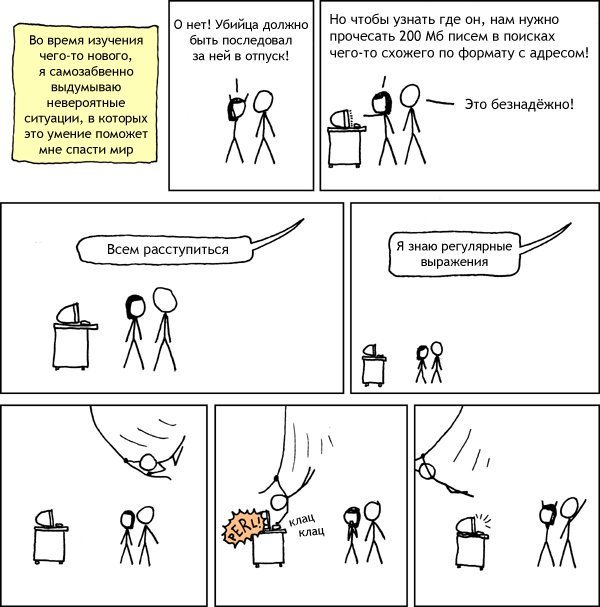

In [ ]:
import re

В регулярных выражениях, кроме привычных символов-букв, есть специальные символы:
* **?а** - ноль или один символ **а**
* **+а** - один или более символов **а**
* **\*а** - ноль или более символов **а** (не путать с +)
* **.** - любое количество любого символа

Пример:
Выражению \*a?b. соответствуют последовательности a, ab, abc, aa, aac НО НЕ abb!

Рассмотрим подробно несколько наиболее полезных функций:

### findall
возвращает список всех найденных непересекающихся совпадений.

Регулярное выражение **ab+c.**: 
* **a** - просто символ **a**
* **b+** - один или более символов **b**
* **c** - просто символ **c**
* **.** - любой символ


In [ ]:
result = re.findall('ab+c.', 'abcdefghijkabcabcxabc') 
print(result)

['abcd', 'abca']


Вопрос на внимательность: почему нет abcx?

**Ответ:** Потому что ищет все *непересекающиеся* совпадения

**Задание**: вернуть список первых двух букв каждого слова в строке, состоящей из нескольких слов.

In [ ]:
find_test_txt = 'Two roads diverged in a yellow wood, And sorry I could not travel both'
re.findall(r'\b\w{1,2}', find_test_txt) 

['Tw',
 'ro',
 'di',
 'in',
 'a',
 'ye',
 'wo',
 'An',
 'so',
 'I',
 'co',
 'no',
 'tr',
 'bo']

### split
разделяет строку по заданному шаблону


In [ ]:
result = re.split(',', 'itsy, bitsy, teenie, weenie') 
print(result)

['itsy', ' bitsy', ' teenie', ' weenie']


можно указать максимальное количество разбиений

In [ ]:
result = re.split(',', 'itsy, bitsy, teenie, weenie', maxsplit=2) 
print(result)

['itsy', ' bitsy', ' teenie, weenie']


**Задание**: разбейте строку, состоящую из нескольких предложений, по точкам, но не более чем на 3 предложения.

In [ ]:
split_test_txt1 = '1 sent. 2 sent. 3 sent. 4 sent. 5 sent.'
print(re.split('[.]', split_test_txt1, maxsplit=2))

split_test_txt2 = 'The first bitcoin upgrade in four years has just gone live. It is a rare moment of consensus among stakeholders, and it’s a big deal for the world’s most popular cryptocurrency. The Taproot update means greater transaction privacy and efficiency – and crucially, it will unlock the potential for smart contracts, which can be used to eliminate middlemen from transactions. “Taproot matters, because it opens a breadth of opportunity for entrepreneurs interested in expanding bitcoin’s utility,” said Alyse Killeen, founder and managing partner of bitcoin-focused venture firm Stillmark. Unlike bitcoin’s 2017 upgrade – referred to as the “last civil war” because of the contentious ideological divide separating adherents – Taproot has near universal support, in part because these changes involve fairly incremental improvements to the code.' 
print(re.split('[.]', split_test_txt2, maxsplit=2))

['1 sent', ' 2 sent', ' 3 sent. 4 sent. 5 sent.']
['The first bitcoin upgrade in four years has just gone live', ' It is a rare moment of consensus among stakeholders, and it’s a big deal for the world’s most popular cryptocurrency', ' The Taproot update means greater transaction privacy and efficiency – and crucially, it will unlock the potential for smart contracts, which can be used to eliminate middlemen from transactions. “Taproot matters, because it opens a breadth of opportunity for entrepreneurs interested in expanding bitcoin’s utility,” said Alyse Killeen, founder and managing partner of bitcoin-focused venture firm Stillmark. Unlike bitcoin’s 2017 upgrade – referred to as the “last civil war” because of the contentious ideological divide separating adherents – Taproot has near universal support, in part because these changes involve fairly incremental improvements to the code.']


### sub
ищет шаблон в строке и заменяет все совпадения на указанную подстроку

параметры: (pattern, repl, string)

In [ ]:
result = re.sub('a', 'b', 'abcabc')
print (result)

bbcbbc


**Задание**: напишите регулярное выражение, которое позволит заменить все цифры в строке на "DIG".

In [ ]:
sub_test_txt1 = 'The Bitcoin stock-to-flow (S2F) model created by pseudonymous analyst PlanB, which analyzes the supply dynamics of Bitcoin and its scarcity enforced by the protocol’s halving of miner rewards every four years, is predicting a monthly close of around $98,000 for November.'
print(sub_test_txt1)

print(re.sub('\d', 'DIG', sub_test_txt1))

The Bitcoin stock-to-flow (S2F) model created by pseudonymous analyst PlanB, which analyzes the supply dynamics of Bitcoin and its scarcity enforced by the protocol’s halving of miner rewards every four years, is predicting a monthly close of around $98,000 for November.
The Bitcoin stock-to-flow (SDIGF) model created by pseudonymous analyst PlanB, which analyzes the supply dynamics of Bitcoin and its scarcity enforced by the protocol’s halving of miner rewards every four years, is predicting a monthly close of around $DIGDIG,DIGDIGDIG for November.


**Задание**: напишите  регулярное выражение, которое позволит убрать url из строки.

In [ ]:
sub_test_txt2 = 'According to PlanB, his model’s predictions have actualized — for the most part. The analyst shared ( https://www.nasdaq.com/articles/stock-to-flow-targets-%2498000-bitcoin-by-end-of-november-will-it-actualize-2021-11-01 ) that both August and September resonated closely with the actual monthly closing price of $47,000 and $43,000, respectively.'
print(sub_test_txt2)

print(re.sub('http\S+', '', sub_test_txt2))

According to PlanB, his model’s predictions have actualized — for the most part. The analyst shared ( https://www.nasdaq.com/articles/stock-to-flow-targets-%2498000-bitcoin-by-end-of-november-will-it-actualize-2021-11-01 ) that both August and September resonated closely with the actual monthly closing price of $47,000 and $43,000, respectively.
According to PlanB, his model’s predictions have actualized — for the most part. The analyst shared (  ) that both August and September resonated closely with the actual monthly closing price of $47,000 and $43,000, respectively.


Больше о крипторынке: https://t.me/css_trade


In [ ]:
sub_test_txt3 = 'Больше о крипторынке: https://t.me/css_trade'
print(sub_test_txt3)

print(re.sub('http\S+', '', sub_test_txt3))

Больше о крипторынке: https://t.me/css_trade
Больше о крипторынке: 


### compile
компилирует регулярное выражение в отдельный объект

In [ ]:
# Пример: построение списка всех слов строки:
prog = re.compile('[А-Яа-яё\-]+')
prog.findall("Слова? Да, больше, ещё больше слов! Что-то ещё.")

['Слова', 'Да', 'больше', 'ещё', 'больше', 'слов', 'Что-то', 'ещё']

**Задание**: для выбранной строки постройте список слов, которые длиннее трех символов.

In [ ]:
pattern1 = re.compile('[А-Яа-яё\-]{4,}')
pattern1.findall("Слова? Да, больше, ещё больше слов! Что-то ещё.")

['Слова', 'больше', 'больше', 'слов', 'Что-то']

**Задание**: вернуть список доменов (@gmail.com) из списка адресов электронной почты:

```
abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz
```

In [ ]:
pattern2 = re.compile('\S+@gmail.com')
pattern2.findall("abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz")

['abc.test@gmail.com']